## 전처리 과정 
### 필요하다고 생각되는 전처리 과정들
- 결측치 처리는 해당사항 없음
### 0. EDA
### 1.  Target Labeling / Encoding 작업 필요 (e : 0, p : 1)
    - df['class'] = df['class'].map({'e' : 0, 'p':1})
### 2. Feature Endocing 
    - cap-shape, cap-color, odor, gill-color 등 대부분이 알파벳으로 된 범주형 변수
    - 해당 컬럼들은 모두 label encoding 혹은 One-Hot Encoding 작업 필요
    - df_dncoded = pd.get_dummies(df.drop('class', axis=1))
    
### 3. Feature/Label 분리 
### 4. Train/Test 분리 
### 5. Feature Importance 탐색 (odor 가 독성에 영향을 많이 준다고 함)
### 6. 모델 선정 및 학습
### 7. 성능 지표 확인하기 (f1-score, Confusion matrix)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score
from xgboost import XGBClassifier

In [2]:
# 1-1) checking Dtype by columns
df = pd.read_csv("mushrooms.csv")

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

## 1-1) Check basic statistics by Using describe()

In [3]:
print(df.describe())

       class cap-shape cap-surface cap-color bruises  odor gill-attachment  \
count   8124      8124        8124      8124    8124  8124            8124   
unique     2         6           4        10       2     9               2   
top        e         x           y         n       f     n               f   
freq    4208      3656        3244      2284    4748  3528            7914   

       gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
count          8124      8124       8124  ...                     8124   
unique            2         2         12  ...                        4   
top               c         b          b  ...                        s   
freq           6812      5612       1728  ...                     4936   

       stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
count                    8124                   8124      8124       8124   
unique                      9                      9         1          4   
top    

In [4]:
df.head(3)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m


## 1-7) 결손 데이터 처리해보기.
결측 데이터는 '?'로 설정 되어있음. -> 해당 데이터를 Nan으로 바꿈으로써 결측값 처리를 해보자

In [5]:
df = df.replace('?', np.nan)

In [6]:
print(df.isnull().sum())

class                          0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64


- 해당 stalk-root column은 2480개의 결측값이 있음
- stalk-root column을 삭제하기

In [7]:
df = df.drop(labels=['stalk-root'], axis=1)

In [8]:
df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


## 추가로 veil-type column 부터 마지막 column까지 모두 drop
-> EDA 결과 해당 Columns 은 mushroom의 독성과 큰 연관이 없다고 판단

In [9]:
df = df.drop(df.columns[15:], axis=1)
df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring
0,p,x,s,n,t,p,f,c,n,k,e,s,s,w,w
1,e,x,s,y,t,a,f,c,b,k,e,s,s,w,w
2,e,b,s,w,t,l,f,c,b,n,e,s,s,w,w
3,p,x,y,w,t,p,f,c,n,n,e,s,s,w,w
4,e,x,s,g,f,n,f,w,b,k,t,s,s,w,w
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,e,s,s,o,o
8120,e,x,s,n,f,n,a,c,b,y,e,s,s,o,o
8121,e,f,s,n,f,n,a,c,b,n,e,s,s,o,o
8122,p,k,y,n,f,y,f,c,n,b,t,s,k,w,w


## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# 2. 분류 데이터 사용할 수 있게 가공해보기
1. 독립 변수, 종속 변수 결정하기 
2. 독립 변수, 종속 변수로 쓰지 않을 컬럼들은 Drop하기 
3. 결손값 처리해보기 
4. 새로운 DataFrame에 저장해보기 
5. 새로운 DataFrame을 종속변수 (Y, Target)과 독립변수 (X, Feature)로 나누어 각각 저장하기 [목표 : 종속 변수] [feature : 독립변수]

### Column별 데이터 설명 
- class : 식용(e) / 독(p)
- cap-shape : 버섯 머리 모양 
- cap-surface : 버섯 머리 표면 (섬유, 비닐처럼 뒤덮힌..., 물결모양)
- cap-color : 버섯 머리 색
- bruises : 멍..?
- odor : 냄새 (nutty한 냄새인지, 비린내, 톡쏘는 냄새 등)
- gill-attachment : 버섯의 아가미 (버섯 머리 밑부분) [ 참고 사진 밑에 첨부 ]
- gill-spacing & gill-size : 각 버섯 아가미의 밀도와 사이즈
- gill-color : 버섯 아가미의 색
- stalk-root : 

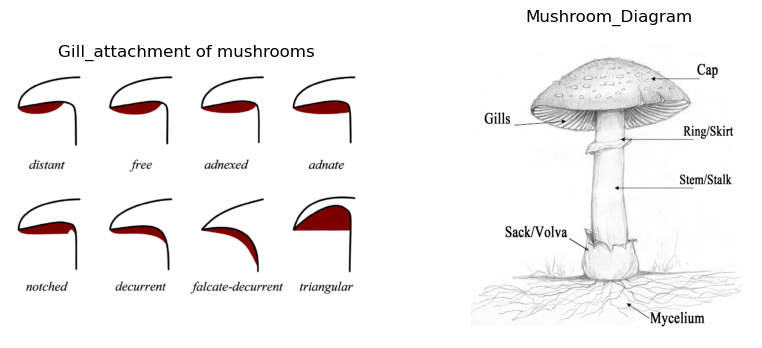

In [10]:
img1 = cv2.imread('gill_attachment.png')
img2 = cv2.imread("Mushroom_Diagram.jpg")

fig = plt.figure(figsize=(10, 4))
rows=1
cols=2

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.set_title("Gill_attachment of mushrooms")
ax1.axis("off")

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.set_title("Mushroom_Diagram")
ax2.axis("off")
#show iage
plt.show()

## 2-1) 목표 변수 및 독립 변수 설정하기 

해당 분류 모델은 버섯이 독버섯인지, 식용인지 구별하는 것. 
- 따라서 목표 변수는 class column으로 정한다. 
- 그 외의 모든 col은 독립변수로 설정, 

## EDA
독성과 버섯의 냄새(odor)가 강한 상관성이 있다는 가설을 세우고, 해당 가설을 검증해보자

In [11]:
pd.crosstab(df['class'], df['odor'])
# almond 냄새 -> edible(400)
# none -> edible(3408)
# foul 냄새 -> poison (2160)
# fishy & spicy -> poison (576 for each)

odor,a,c,f,l,m,n,p,s,y
class,,,,,,,,,
e,400,0,0,400,0,3408,0,0,0
p,0,192,2160,0,36,120,256,576,576


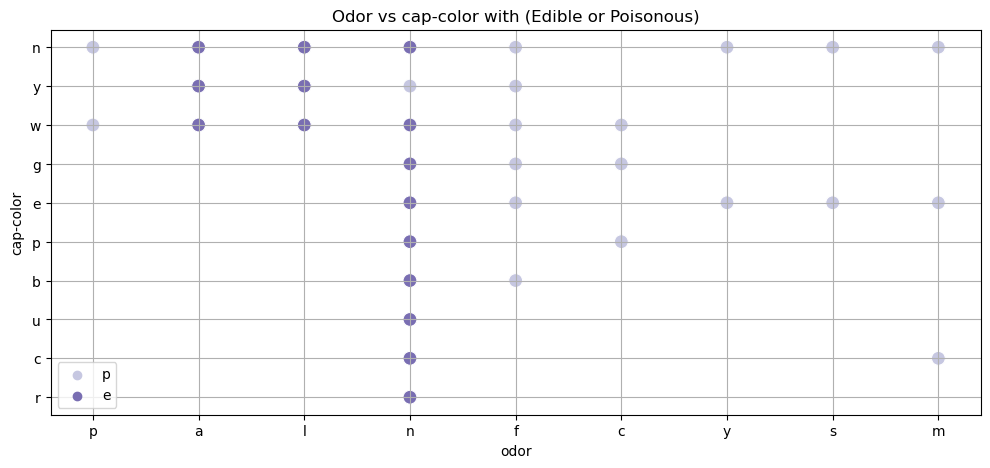

In [12]:
plt.figure(figsize=(12,5))
sns.scatterplot(x=df['odor'], y=df['cap-color'], hue=df['class'], s=100, palette='Purples')
plt.title("Odor vs cap-color with (Edible or Poisonous)")
plt.legend()
plt.grid()
plt.show()

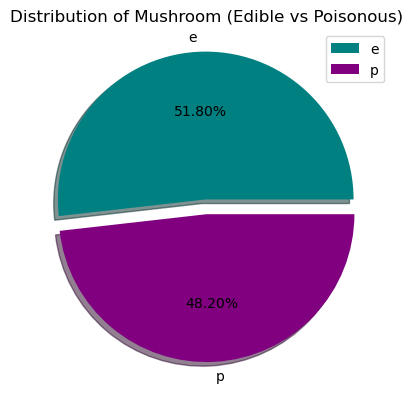

In [13]:
mushroom_edible = df['class'].value_counts()
plt.figure()
plt.pie(mushroom_edible.values,labels = mushroom_edible.index, autopct='%.2f%%', 
        colors=['teal', 'purple'], explode = [0.1, 0], shadow=True)
plt.title("Distribution of Mushroom (Edible vs Poisonous)")
plt.legend()
plt.show()

## EDA-2 : Correlations between veil and mushrooms' poisonous

In [14]:
pd.crosstab(df['class'], df['gill-spacing'])
# pd.crosstab(df['class'], df['bruises'])

gill-spacing,c,w
class,,
e,3008,1200
p,3804,112


In [15]:
# Target Encoding
df['class'] = df['class'].map({'e':0, 'p':1}).astype(int)

In [16]:
df

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring
0,1,x,s,n,t,p,f,c,n,k,e,s,s,w,w
1,0,x,s,y,t,a,f,c,b,k,e,s,s,w,w
2,0,b,s,w,t,l,f,c,b,n,e,s,s,w,w
3,1,x,y,w,t,p,f,c,n,n,e,s,s,w,w
4,0,x,s,g,f,n,f,w,b,k,t,s,s,w,w
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,k,s,n,f,n,a,c,b,y,e,s,s,o,o
8120,0,x,s,n,f,n,a,c,b,y,e,s,s,o,o
8121,0,f,s,n,f,n,a,c,b,n,e,s,s,o,o
8122,1,k,y,n,f,y,f,c,n,b,t,s,k,w,w


# Label Encoding And split into train/test data sets
- Label Encoding은 반드시 train_test_split 이전에 적용하기 
    - Label Encoding은 '범주'를 숫자로 매핑하는데, test set에만 존재하는 범주가 있다면 ValueError 발생

In [17]:
df_encoded = df.copy()
le = LabelEncoder()
for col in df.columns:
    df_encoded[col] = le.fit_transform(df[col])
    
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)
print(f"X_train Shape : {X_train.shape}")
print(f"y_train Shape : {y_train.shape}")
print(f"X_test Shape : {X_test.shape}")
print(f"y_test Shape : {y_test.shape}")

X_train Shape : (6093, 14)
y_train Shape : (6093,)
X_test Shape : (2031, 14)
y_test Shape : (2031,)


## Models
- 모델 별 주요 특징 및 비교
    - RandomForest Classifier : 
        - 기본 결정 트리는 과적합 현상이 많아 앙상블 기법으로 고안된 새로운 트리 알고리즘 분류기
        - 다수의 결정 트리들을 랜덤하게 학습시켜 분류 or 회귀의 결과 도출에 사용
        - 
    <br></br>
    - Gradient Boosting Classifier : 
        <br></br>

    - Naive Bayes : 
        <br></br>
    - Decision Tree Classifier : 
        <br></br>
    - XGBoost Classifier : 
        <br></br>
    - K-means Clustering : 

In [18]:
scaler = StandardScaler()
scaler.fit(X_train, X_test)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
classification_models={
    "Random Forest Classifier" : RandomForestClassifier(),
    "Gradient Boosting Classifier" : GradientBoostingClassifier(),
    "Naive Bayes" : GaussianNB(),
    "Decision Tree Classifier" : DecisionTreeClassifier(),
    "XGBoost Classifier" : XGBClassifier(),
    "K-means Clustering" : KNeighborsClassifier(n_neighbors=5)
}

## K 값에 따른 정확도 비교 분석 (KNN Classifier)

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred_knn_train = knn.predict(X_train)
print("KNN Train 정확도 : ", accuracy_score(y_train, y_pred_knn_train))

KNN Train 정확도 :  0.9981946495978993


In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn = KNeighborsClassifier(n_neighbors=1000)
knn.fit(X_train, y_train)

y_pred_knn_train = knn.predict(X_train)
print("KNN Train 정확도 : ", accuracy_score(y_train, y_pred_knn_train))

KNN Train 정확도 :  0.8380108321024126


## 교차검증 (K fold, Stratified Kfold, cross_val_score) 이후 정확도 비교

## 팀 내 통일화 한 수정 코드 반영

### Kfold

In [23]:
print(type(X))

<class 'pandas.core.frame.DataFrame'>


In [58]:
cv_scores_kfold = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in classification_models.items():
    cv_accuracy_kfold = []
    n_iter = 0
    print(f"\n [{name}]")
    
    for train_idx, val_idx in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        if name in ['KNN', 'Logistic Regression', 'SGD Classifier']:
            scaler = StandardScaler()
            X_train_fold = scaler.fit_transform(X_train_fold)
            X_val_fold = scaler.transform(X_val_fold)

        try:
            model.fit(X_train_fold, y_train_fold)
            pred = model.predict(X_val_fold)
            acc = np.round(accuracy_score(y_val_fold, pred), 4)
            cv_accuracy_kfold.append(acc)
            
            n_iter += 1
            print(f'#{n_iter} 교차검증 정확도 : {acc}, 학습 크기 : {X_train_fold.shape[0]}, 검증 크기 : {X_val_fold.shape[0]}')
            
        except Exception as e:
            print(f"[KFold] {name} 오류: {e}")
            break
        
    if cv_accuracy_kfold:
        mean_acc = np.mean(cv_accuracy_kfold)
        std_acc = np.std(cv_accuracy_kfold)
        
        print(f"{name} 평균 검증 정확도 : {mean_acc:.4f} / 표준편차 : {std_acc:.4f}")

    cv_scores_kfold[name] = cv_accuracy_kfold


 [Random Forest Classifier]
#1 교차검증 정확도 : 0.9994, 학습 크기 : 6499, 검증 크기 : 1625
#2 교차검증 정확도 : 0.9969, 학습 크기 : 6499, 검증 크기 : 1625
#3 교차검증 정확도 : 0.9982, 학습 크기 : 6499, 검증 크기 : 1625
#4 교차검증 정확도 : 1.0, 학습 크기 : 6499, 검증 크기 : 1625
#5 교차검증 정확도 : 0.9982, 학습 크기 : 6500, 검증 크기 : 1624
Random Forest Classifier 평균 검증 정확도 : 0.9985 / 표준편차 : 0.0011

 [Gradient Boosting Classifier]
#1 교차검증 정확도 : 0.9988, 학습 크기 : 6499, 검증 크기 : 1625
#2 교차검증 정확도 : 0.9963, 학습 크기 : 6499, 검증 크기 : 1625
#3 교차검증 정확도 : 0.9957, 학습 크기 : 6499, 검증 크기 : 1625
#4 교차검증 정확도 : 0.9938, 학습 크기 : 6499, 검증 크기 : 1625
#5 교차검증 정확도 : 0.9963, 학습 크기 : 6500, 검증 크기 : 1624
Gradient Boosting Classifier 평균 검증 정확도 : 0.9962 / 표준편차 : 0.0016

 [Naive Bayes]
#1 교차검증 정확도 : 0.9095, 학습 크기 : 6499, 검증 크기 : 1625
#2 교차검증 정확도 : 0.8966, 학습 크기 : 6499, 검증 크기 : 1625
#3 교차검증 정확도 : 0.9046, 학습 크기 : 6499, 검증 크기 : 1625
#4 교차검증 정확도 : 0.8942, 학습 크기 : 6499, 검증 크기 : 1625
#5 교차검증 정확도 : 0.9039, 학습 크기 : 6500, 검증 크기 : 1624
Naive Bayes 평균 검증 정확도 : 0.9018 / 표준편차 : 0.0056

 [Decision Tree Cl

### Stratified Kfold

In [57]:
cv_scores_stratified = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in classification_models.items():
    cv_accuracy_skfold = []
    n_iter = 0
    print(f"\n [{name}]")

    for train_idx, val_idx in skf.split(X, y):
        X_train_sfold, X_val_sfold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_sfold, y_val_sfold = y.iloc[train_idx], y.iloc[val_idx]

        if name in ['KNN', 'Logistic Regression', 'SGD Classifier']:
            scaler = StandardScaler()
            X_train_sfold = scaler.fit_transform(X_train_sfold)
            X_val_sfold = scaler.transform(X_val_sfold)

        try:
            model.fit(X_train_sfold, y_train_sfold)
            pred = model.predict(X_val_sfold)
            acc = np.round(accuracy_score(y_val_sfold, pred), 4)
            cv_accuracy_skfold.append(acc)
            
            n_iter += 1
            print(f'#{n_iter} 교차검증 정확도 : {acc}, 학습 크기 : {X_train_sfold.shape[0]}, 검증 크기 : {X_val_sfold.shape[0]}')
            
        except Exception as e:
            print(f"[StratifiedKFold] {name} 오류: {e}")
            break

    if cv_accuracy_skfold:
        mean_acc = np.mean(cv_accuracy_skfold)
        std_acc = np.std(cv_accuracy_skfold)
        
        print(f"{name} 평균 검증 정확도 : {mean_acc:.4f} / 표준편차 : {std_acc:.4f}")

    cv_scores_stratified[name] = cv_accuracy_skfold


 [Random Forest Classifier]
#1 교차검증 정확도 : 0.9982, 학습 크기 : 6499, 검증 크기 : 1625
#2 교차검증 정확도 : 1.0, 학습 크기 : 6499, 검증 크기 : 1625
#3 교차검증 정확도 : 0.9994, 학습 크기 : 6499, 검증 크기 : 1625
#4 교차검증 정확도 : 0.9988, 학습 크기 : 6499, 검증 크기 : 1625
#5 교차검증 정확도 : 0.9988, 학습 크기 : 6500, 검증 크기 : 1624
Random Forest Classifier 평균 검증 정확도 : 0.9990 / 표준편차 : 0.0006

 [Gradient Boosting Classifier]
#1 교차검증 정확도 : 0.9963, 학습 크기 : 6499, 검증 크기 : 1625
#2 교차검증 정확도 : 0.9969, 학습 크기 : 6499, 검증 크기 : 1625
#3 교차검증 정확도 : 0.9969, 학습 크기 : 6499, 검증 크기 : 1625
#4 교차검증 정확도 : 0.9932, 학습 크기 : 6499, 검증 크기 : 1625
#5 교차검증 정확도 : 0.9957, 학습 크기 : 6500, 검증 크기 : 1624
Gradient Boosting Classifier 평균 검증 정확도 : 0.9958 / 표준편차 : 0.0014

 [Naive Bayes]
#1 교차검증 정확도 : 0.8917, 학습 크기 : 6499, 검증 크기 : 1625
#2 교차검증 정확도 : 0.9009, 학습 크기 : 6499, 검증 크기 : 1625
#3 교차검증 정확도 : 0.9126, 학습 크기 : 6499, 검증 크기 : 1625
#4 교차검증 정확도 : 0.9071, 학습 크기 : 6499, 검증 크기 : 1625
#5 교차검증 정확도 : 0.8972, 학습 크기 : 6500, 검증 크기 : 1624
Naive Bayes 평균 검증 정확도 : 0.9019 / 표준편차 : 0.0073

 [Decision Tree Cl

## 왜 Kfold가 StratifiedKFold보다 점수가 높을까?
- StratifiedKFold의 목적은 '성능 향상'이 아니라 '공정한 평가'이기 때문에 공정할 뿐, 높은 성능을 보장하지는 않음 

## GridSearchCV 를 통해 최적 파라미터 찾기
- 모델의 하이퍼 파라미터값은 사용자가 직접 리스트로 지정하는것.
    - 무지성으로 막 넣는것이 아닌, 모델 성능 개선을 위한 경험, 논문, 튜토리얼, 실험 등을 참고하여 설정

In [27]:
#dtree_forGS = DecisionTreeClassifier()
dtree_forGS = RandomForestClassifier()

parameters ={'max_depth' : [1, 2, 3], 'min_samples_split':[2, 3]}

grid_dtree = GridSearchCV(dtree_forGS, param_grid=parameters, cv=3, refit=True)
grid_dtree.fit(X_train, y_train)

scores_df_GS = pd.DataFrame(grid_dtree.cv_results_)
scores_df_GS[['params', 'mean_test_score', 'rank_test_score',
             'split0_test_score', 'split1_test_score', 'split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 1, 'min_samples_split': 2}",0.898900,5,0.892664,0.904973,0.899065
1,"{'max_depth': 1, 'min_samples_split': 3}",0.898900,5,0.903496,0.913343,0.879862
2,"{'max_depth': 2, 'min_samples_split': 2}",0.933694,4,0.923683,0.933530,0.943870
3,"{'max_depth': 2, 'min_samples_split': 3}",0.942885,3,0.947809,0.949286,0.931561
4,"{'max_depth': 3, 'min_samples_split': 2}",0.967832,2,0.973904,0.967996,0.961595
5,"{'max_depth': 3, 'min_samples_split': 3}",0.970458,1,0.970458,0.967011,0.973904


In [28]:
print("GridSearchCV 최적 파라미터 : ", grid_dtree.best_params_)
print('GridSearchCV 최고 정확도 : {0:.4f}'.format(grid_dtree.best_score_))

GridSearchCV 최적 파라미터 :  {'max_depth': 3, 'min_samples_split': 3}
GridSearchCV 최고 정확도 : 0.9705


In [29]:
# GridSearchCV의 refit으로 이미 학습된 estimator 반환
estimator_gs = grid_dtree.best_estimator_

# GridSearchCV의 best_estimator_는 이미 최적 학습이 됐으므로 별도 학습이 필요 없음
pred_gs = estimator_gs.predict(X_test)
print("테스트 데이터 세트 정확도 : {0:.4f}".format(accuracy_score(y_test, pred_gs)))

테스트 데이터 세트 정확도 : 0.9675


### Cross_val_score
- cross_val_score() 
    - estimator : estimator
        - 학습 할 모델을 의미한다. 
    - x : array
        - 학습시킬 훈련 데이터 세트
    - y : array
        - 학습시킬 훈련 데이터 세트의 Label 
    - scoring : string or None
        - 각 모델에서 사용할 평가 방법
        - 교차 검증은 utility funtion을 사용한다. 그래서 더 큰 값이 좋은 결과라는 의미
        - 위와 같은 이유로 Regression 모델에서는 MSE를 얻기 위해 주로 'neg_mean_squred_error'값을 사용
        
    - cv : int or kfold
        - Cross-Validation generator
        - Fold의 수를 의미 
        - 앞서 정리한 교차 검증 반복자를 사용. 또는, custom한 Fold를 생성하는 iteraotr를 만들어도 좋음
        

In [30]:
from sklearn.model_selection import cross_val_score

result = []

for names, model in classification_models.items():
    scores = cross_val_score(model, X, y, cv=5)
    # cross_val_scores.append((names, scores))
    
    result.append({
        'Model Name' : names,
        'CV Score' : scores,
#         'Mean Accuracy' : scores.mean(),
#         'Std Dev' : scores.std()
    })
    
summary = pd.DataFrame(result)
print(summary)

                     Model Name  \
0      Random Forest Classifier   
1  Gradient Boosting Classifier   
2                   Naive Bayes   
3      Decision Tree Classifier   
4            XGBoost Classifier   
5            K-means Clustering   

                                            CV Score  
0  [0.8916923076923077, 0.9993846153846154, 0.968...  
1  [0.8523076923076923, 0.9981538461538462, 0.963...  
2  [0.6504615384615384, 0.9753846153846154, 0.805...  
3  [0.9163076923076923, 0.9993846153846154, 0.978...  
4  [0.8547692307692307, 0.9993846153846154, 0.978...  
5  [0.7993846153846154, 0.9963076923076923, 0.917...  


## Cross_val_score() #2

In [31]:
parameters_cross_val = {
    'max_depth' : [3, 5, 10, 15, None],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'criterion' : ['gini', 'entropy']
}

# 조합 생성 (총 90개)
param_list = list(ParameterGrid(parameters_cross_val))

best_score = 0
best_params = None

# 각 조합에 대해 교차 검증 수행 
for params in param_list:
    model = DecisionTreeClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    mean_score = np.mean(scores)
    
    print(f"Params : {params}, Mean CV Score : {mean_score:.4f}")
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
    print("\n최적화된 파라미터 값 : ", best_params)
    print("\n최적화된 파라미터 값의 검증 정확도 : ", round(best_score, 4))

Params : {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}, Mean CV Score : 0.9660

최적화된 파라미터 값 :  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

최적화된 파라미터 값의 검증 정확도 :  0.966
Params : {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}, Mean CV Score : 0.9660

최적화된 파라미터 값 :  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

최적화된 파라미터 값의 검증 정확도 :  0.966
Params : {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}, Mean CV Score : 0.9660

최적화된 파라미터 값 :  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

최적화된 파라미터 값의 검증 정확도 :  0.966
Params : {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}, Mean CV Score : 0.9660

최적화된 파라미터 값 :  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

최적화된 파라미터 값의 검증 정확도 :  0.966
Par

Params : {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}, Mean CV Score : 0.9984

최적화된 파라미터 값 :  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

최적화된 파라미터 값의 검증 정확도 :  0.9984
Params : {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}, Mean CV Score : 0.9974

최적화된 파라미터 값 :  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

최적화된 파라미터 값의 검증 정확도 :  0.9984
Params : {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}, Mean CV Score : 0.9972

최적화된 파라미터 값 :  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

최적화된 파라미터 값의 검증 정확도 :  0.9984
Params : {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}, Mean CV Score : 0.9974

최적화된 파라미터 값 :  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

최적화된

Params : {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}, Mean CV Score : 0.9941

최적화된 파라미터 값 :  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

최적화된 파라미터 값의 검증 정확도 :  0.9984
Params : {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}, Mean CV Score : 0.9939

최적화된 파라미터 값 :  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

최적화된 파라미터 값의 검증 정확도 :  0.9984
Params : {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}, Mean CV Score : 0.9977

최적화된 파라미터 값 :  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

최적화된 파라미터 값의 검증 정확도 :  0.9984
Params : {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5}, Mean CV Score : 0.9977

최적화된 파라미터 값 :  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}

최

## Chapter 3 : Evaluation 

In [32]:
evaluate=[]

for names, model in classification_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, preds)
    p = precision_score(y_test, preds, average='macro')
    
    print(f"\nName : {names}")
    print(f"Accuracy : {accuracy:.2f}")
    print(f"Precision Score : {p}")

    evaluate.append({
        'Model Name' : names,
        'Test Accuracy' : accuracy,
        'Test Precision' : p
    })
    
    summary_df = pd.DataFrame(evaluate)
print("\nSummary:")
summary_df


Name : Random Forest Classifier
Accuracy : 1.00
Precision Score : 0.9995196926032661

Name : Gradient Boosting Classifier
Accuracy : 1.00
Precision Score : 0.9990403071017274

Name : Naive Bayes
Accuracy : 0.91
Precision Score : 0.9083656429979738

Name : Decision Tree Classifier
Accuracy : 1.00
Precision Score : 0.99856184084372

Name : XGBoost Classifier
Accuracy : 1.00
Precision Score : 0.9995196926032661

Name : K-means Clustering
Accuracy : 0.99
Precision Score : 0.9897231091743742

Summary:


,Model Name,Test Accuracy,Test Precision
0,Random Forest Classifier,0.999508,0.999520
1,Gradient Boosting Classifier,0.999015,0.999040
2,Naive Bayes,0.907927,0.908366
3,Decision Tree Classifier,0.998523,0.998562
4,XGBoost Classifier,0.999508,0.999520
5,K-means Clustering,0.989660,0.989723


In [33]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Class 피처가 1(P)인 경우 -> 예측값 0
    #                             피처가 0(e)인 경우1 -> 예측값 1
    def predict(self, X):
        pred = np.zeros(X.shape[0], 1)
        for i in range(X.shape[0]):
            if X['class'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred